[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SeoulTechPSE/EngNm/blob/master/ch09_code.ipynb)

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from scipy import integrate
import sympy
sympy.init_printing()

Python functions for both $f(t, y(t))$ and its Jacobian can conveniently be generated using Sympy's
`lambdify`, provided that the ODE problem first can be defined as a Sympy expression. This symbolic-numeric
hybrid approach is a powerful method to solving ODE problems. To illustrate this approach,
consider the rather complicated system of two coupled second-order and nonlinear ODEs for a double
pendulum.


$$
(m_1+m_2) l_1\theta_1'' + m_2l_2\theta_2''\cos(\theta_1-\theta_2)
+ m_2l_2\left(\theta_2'\right)^2\sin(\theta_1-\theta_2)+g(m_1+m_2)\sin(\theta_1) = 0
$$

$$
m_2l_2\theta_2'' + m_2l_1\theta_1''\cos(\theta_1-\theta_2) - m_2l_1 \left(\theta_1'\right)^2 \sin(\theta_1-\theta_2)
+m_2g\sin(\theta_2) = 0
$$

We begin by defining Sympy symbols for the variables and the functions in the problem, and
then construct the ode expressions:

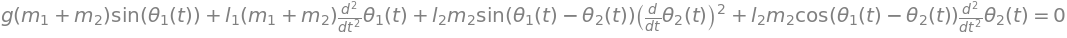

In [2]:
t, g, m1, l1, m2, l2 = sympy.symbols("t, g, m_1, l_1, m_2, l_2")
theta1, theta2 = sympy.symbols("theta_1, theta_2", cls=sympy.Function)

ode1 = sympy.Eq((m1 +m2) *l1 *theta1(t).diff(t,t) +
                m2 *l2 *theta2(t).diff(t,t) *sympy.cos(theta1(t) -theta2(t)) +
                m2 *l2 *theta2(t).diff(t)**2 *sympy.sin(theta1(t) -theta2(t)) + 
                g *(m1 +m2) *sympy.sin(theta1(t)), 0)
ode1

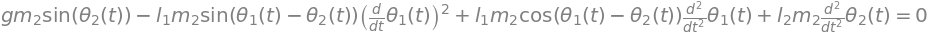

In [3]:
ode2 = sympy.Eq(m2 *l2 *theta2(t).diff(t,t) +
                m2 *l1 *theta1(t).diff(t,t) *sympy.cos(theta1(t) -theta2(t)) -
                m2 *l1 *theta1(t).diff(t)**2 *sympy.sin(theta1(t) -theta2(t)) +
                m2 *g *sympy.sin(theta2(t)), 0)
ode2

Now `ode1` and `ode2` are Sympy expressions for the two second-order ODE equations. We first have to write the system of two second-order ODEs as a system of four first-order ODEs on standard form. To this end we need to introduce new functions $\text{ }y_1(t) = \theta_1(t)$, $\text{ }y_2(t) = \theta_1'(t)$, $\text{ }y_3(t) = \theta_2(t)$, $\text{ }y_4(t) = \theta_2'(t)$, $\text{ }$and rewrite the ODEs in terms of these functions.

In [4]:
y1, y2, y3, y4 = sympy.symbols("y_1, y_2, y_3, y_4", cls=sympy.Function)

varchange = {theta1(t).diff(t, t): y2(t).diff(t), 
             theta1(t): y1(t),
             theta2(t).diff(t, t): y4(t).diff(t), 
             theta2(t): y3(t)}

ode1_vc = ode1.subs(varchange)
ode2_vc = ode2.subs(varchange)
ode3 = y1(t).diff(t) - y2(t)
ode4 = y3(t).diff(t) - y4(t)

At this point, we have four coupled first-order ODEs for the functions $y_1$ to $y_4$. It only remains to solve for the derivatives of these functions to obtain the ODEs in standard form.

In [5]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])
vcsol = sympy.solve((ode1_vc, ode2_vc, ode3, ode4), y.diff(t), dict=True)
f = y.diff(t).subs(vcsol[0])

In [6]:
f

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   g⋅m₂⋅sin(y₁(t) - 2⋅y₃(t)) 
⎢                                 g⋅m₁⋅sin(y₁(t)) + ───────────────────────── 
⎢                                                               2             
⎢                                 ────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

Now $f$ is Sympy expression for the ODE function $f(t, y(t))$. Also, since we have an symbolic representation of the problem so far, it is easy to also compute the Jacobian

In [7]:
jac = sympy.Matrix([[fj.diff(yi) for yi in y] for fj in f])

In [8]:
jac

⎡                                                                             
⎢                                                                             
⎢                                                        ⎛                    
⎢                                                        ⎜                  g⋅
⎢                                                   2⋅m₂⋅⎜g⋅m₁⋅sin(y₁(t)) + ──
⎢                                                        ⎝                    
⎢                                                   ──────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

The main purpose of constructing $f$ and it's Jacobian is to convert them to Numpy-aware functions that can be used with `integrate.solve_ivp` or `integrate.ode`.

In [9]:
params = {m1: 5.0, l1: 2.0, m2: 1.0, l2: 1.0, g: 9.8}

f_np = sympy.lambdify((t, y), f.subs(params), 'numpy')
jac_np = sympy.lambdify((t, y), jac.subs(params), 'numpy')

With the functions `f_np `and `jac_np`, we are now ready to solve the ODE using `integrate.ode` in the same manner as in the
previous examples

In [10]:
y0 = [2.0, 0, 0.0, 0]
t = np.linspace(0, 20, 1000)
r = integrate.ode(f_np, jac_np).set_initial_value(y0, t[0])

In [11]:
dt = t[1] -t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t +dt)
    idx += 1

When visualizing this solution, it is more intuitive to plot the positions of the pendulums in the $x–y$ plane rather than their angular deflections

In [12]:
theta1_np, theta2_np = y[:, 0], y[:, 2]

x1 =  params[l1] *np.sin(theta1_np)
y1 = -params[l1] *np.cos(theta1_np)
x2 = x1 +params[l2] *np.sin(theta2_np)
y2 = y1 -params[l2] *np.cos(theta2_np)

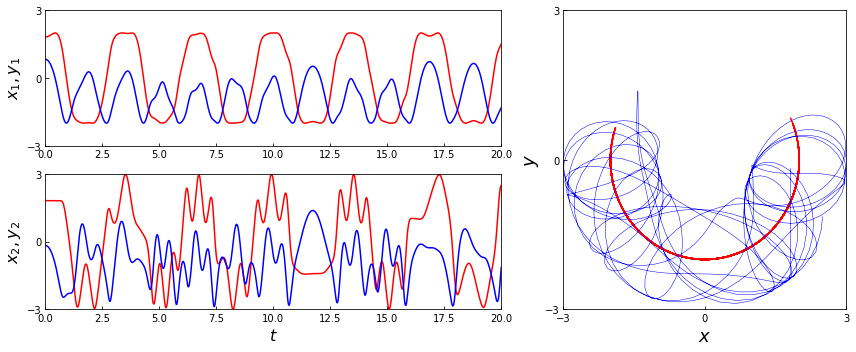

In [13]:
fig = plt.figure(figsize=(12, 5))

ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(t, x1, 'r')
ax1.plot(t, y1, 'b')
ax1.set_ylabel('$x_1, y_1$', fontsize=16)
ax1.set_yticks([-3, 0, 3])
ax1.set_xlim(0, 20), ax1.set_ylim(-3, 3)
ax1.tick_params(which='both', direction='in')

ax2.plot(t, x2, 'r')
ax2.plot(t, y2, 'b')
ax2.set_xlabel('$t$', fontsize=16)
ax2.set_ylabel('$x_2, y_2$', fontsize=16)
ax2.set_yticks([-3, 0, 3])
ax2.set_xlim(0, 20), ax2.set_ylim(-3, 3)
ax2.tick_params(which='both', direction='in')

ax3.plot(x1, y1, 'r')
ax3.plot(x2, y2, 'b', lw=0.5)
ax3.set_xlabel('$x$', fontsize=18)
ax3.set_ylabel('$y$', fontsize=18)
ax3.set_xticks([-3, 0, 3])
ax3.set_yticks([-3, 0, 3])
ax3.set_xlim(-3, 3)
ax3.set_ylim(-3, 3)
ax3.tick_params(which='both', direction='in')

fig.tight_layout()